## Feature Extraction From a Video

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
import os
root='/content/drive/My Drive/Colab Notebooks/Video Summerization'
os.chdir(root)

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pickle
import shutil
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model
from keras.layers import Convolution2D,MaxPool2D,Flatten,Dense,Dropout,GlobalAveragePooling2D,Input
from keras.optimizers import Adam
%matplotlib inline

In [7]:
ResNet50V2 = tf.keras.applications.resnet_v2.ResNet50V2(
      include_top=False,
      weights="imagenet",
      input_shape=(243,432, 3), ##(432,243,3) for 16:9 || (480,360) for 4:3 || (640,480) for 4:3|| (960,720) for 4:3
)

In [8]:
MobileNetV2 = tf.keras.applications.MobileNetV2(
      include_top=False,
      weights="imagenet",
      input_shape=(243,432, 3),
)

In [9]:
InceptionResNetV2 = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
      include_top=False,
      weights="imagenet",
      input_shape=(243,432, 3), ##(432,243,3) for 16:9 || (480,360) for 4:3 || (640,480) for 4:3|| (960,720) for 4:3
)

In [10]:
VGG16 = tf.keras.applications.vgg16.VGG16(
      include_top=False,
      weights="imagenet",
      input_shape=(243,432, 3),
)

In [11]:
ResNet152V2 = tf.keras.applications.resnet_v2.ResNet152V2(
      include_top=False,
      weights="imagenet",
      input_shape=(243,432, 3),
)

In [12]:
model={'resnet50':ResNet50V2,'resnet152':ResNet152V2,'vgg16':VGG16,'irnv2':InceptionResNetV2,'mobilenet':MobileNetV2}

In [11]:
train_dir='/content/drive/My Drive/Colab Notebooks/Video Summerization/human detection dataset'

img_width,img_height=432,243

### Generating more data point and extract feature

In [12]:
import glob
trainImg=[]
trainLabels=[]
i=0
for directory_path in glob.glob(train_dir+'/*'):
  label=directory_path.split('/')[-1]
  for imgPath in glob.glob(os.path.join(directory_path,'*.png')):
    print(imgPath)
    img=cv2.imread(imgPath,cv2.IMREAD_COLOR)
    img=cv2.resize(img,(img_width,img_height))
    trainImg.append(img)
    trainLabels.append(label)
trainImg=np.array(trainImg)
trainLabel=np.array(trainLabels)

/content/drive/My Drive/Colab Notebooks/Video Summerization/human detection dataset/0/0.png
/content/drive/My Drive/Colab Notebooks/Video Summerization/human detection dataset/0/1.png
/content/drive/My Drive/Colab Notebooks/Video Summerization/human detection dataset/0/114.png
/content/drive/My Drive/Colab Notebooks/Video Summerization/human detection dataset/0/178.png
/content/drive/My Drive/Colab Notebooks/Video Summerization/human detection dataset/0/172.png
/content/drive/My Drive/Colab Notebooks/Video Summerization/human detection dataset/0/144.png
/content/drive/My Drive/Colab Notebooks/Video Summerization/human detection dataset/0/185.png
/content/drive/My Drive/Colab Notebooks/Video Summerization/human detection dataset/0/198.png
/content/drive/My Drive/Colab Notebooks/Video Summerization/human detection dataset/0/121.png
/content/drive/My Drive/Colab Notebooks/Video Summerization/human detection dataset/0/113.png
/content/drive/My Drive/Colab Notebooks/Video Summerization/huma

In [13]:
trainImg.shape

(928, 243, 432, 3)

In [14]:
uniques,count=np.unique(trainLabel,return_counts=True)
print(np.asarray((uniques, count)).T)

[['0' '362']
 ['1' '566']]


In [15]:
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
trainLabel=le.fit_transform(trainLabel)
trainLabel=np.array(trainLabel,dtype=int)

In [17]:
trainData=(trainImg,trainLabel)

In [16]:
#Preparing for Augumentation
datagen = ImageDataGenerator(shear_range=0.2,
                             zoom_range=0.2,
                             rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             )

In [18]:
def extract_features(Data, sample_count,datagen,base):
    # To retain the trained weight
    for layers in base.layers:
      layers.trainable=False

    # Flattening
    extract=Sequential()
    extract.add(base)
    extract.add(Flatten())
    extract.compile(optimizer='adam',loss='binary_crossentropy')

    # Initialize feature array and label array
    features = np.zeros(shape=(sample_count*2, extract.output_shape[1]))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count*2,))

    # Preprocess data
    batch_size = 32
    generator = datagen.flow(Data,batch_size = batch_size)
    
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = extract.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= (2*sample_count):
            break
    return features/255.0, labels
# Extract features    
train_features, train_labels = extract_features(trainData,trainImg.shape[0],datagen,base=model['vgg16'])  # Agree with our small dataset size

1/1 [==============================] - 0s 35ms/step


In [20]:
import pickle
dt=[train_features, train_labels]
with open('array_'+str(model['vgg16']), 'wb') as files:
    pickle.dump(dt, files)

### Extracting feature From the directory images

In [14]:
data= pickle.load(open('array_'+str(model['vgg16']), 'rb'))

In [5]:
data= pickle.load(open('array_ResNet50V2', 'rb'))

In [6]:
from sklearn.model_selection import train_test_split
xTrain,xTest,yTrain,yTest=train_test_split(data[0],data[1],test_size=0.2,random_state=42)    #,validation_features,validation_labels

In [7]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=50,random_state=42)
rf.fit(xTrain,yTrain)
y=rf.predict(xTest)

In [8]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
print(precision_score(yTest,y))
print(recall_score(yTest,y))
print(f1_score(yTest,y))

0.673992673992674
0.8363636363636363
0.7464503042596349


In [ ]:
with open('model_ResNet50V2_rf', 'wb') as files:
    pickle.dump(rf, files)

In [ ]:
epochs = 500

model = Sequential()
model.add(Input(shape=(None,xTrain.shape[1])))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, None, 128)         14155904  
                                                                 
 dropout_8 (Dropout)         (None, None, 128)         0         
                                                                 
 dense_17 (Dense)            (None, None, 128)         16512     
                                                                 
 dropout_9 (Dropout)         (None, None, 128)         0         
                                                                 
 dense_18 (Dense)            (None, None, 128)         16512     
                                                                 
 dense_19 (Dense)            (None, None, 1)           129       
                                                                 
Total params: 14,189,057
Trainable params: 14,189,057


In [ ]:
#early stopping
early=tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                       patience=15,
                                       mode='min')

In [ ]:
# Compile model
from keras.optimizers import Adam
model.compile(optimizer=Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['acc'],
              )

In [ ]:
# Train model
history = model.fit(xTrain,yTrain,
                    epochs=epochs,
                    batch_size=128, 
                    callbacks=[early],
                    shuffle=False,
                    validation_data=(xTest,yTest))

Epoch 1/107


11/12 [==========================>...] - ETA: 0s - loss: 0.7983 - acc: 0.5206

12/12 [==============================] - 1s 66ms/step - loss: 0.7930 - acc: 0.5222 - val_loss: 0.6792 - val_acc: 0.5511
Epoch 2/107
12/12 [==============================] - 1s 44ms/step - loss: 0.7165 - acc: 0.5411 - val_loss: 0.6558 - val_acc: 0.6559
Epoch 3/107
12/12 [==============================] - 1s 43ms/step - loss: 0.7177 - acc: 0.5142 - val_loss: 0.6697 - val_acc: 0.6263
Epoch 4/107
12/12 [==============================] - 1s 50ms/step - loss: 0.7015 - acc: 0.5377 - val_loss: 0.6734 - val_acc: 0.6425
Epoch 5/107
12/12 [==============================] - 1s 43ms/step - loss: 0.6872 - acc: 0.5620 - val_loss: 0.6617 - val_acc: 0.6586
Epoch 6/107
12/12 [==============================] - 1s 44ms/step - loss: 0.6928 - acc: 0.5465 - val_loss: 0.6517 - val_acc: 0.6478
Epoch 7/107
12/12 [==============================] - 1s 43ms/step - loss: 0.6898 - acc: 0.5627 - val_loss: 0.6542 - val_acc: 0.6559
Epoch 8/107
12/12 [==============================] - 1s 44ms/step - loss: 0.6851 - acc: 

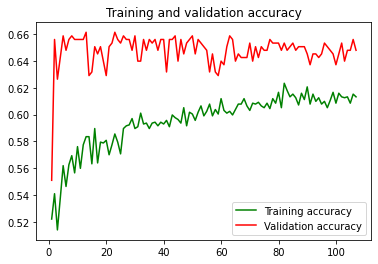

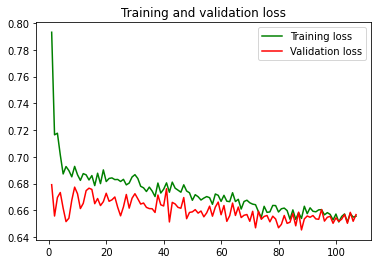

In [ ]:
 # Plot results
import matplotlib.pyplot as plt


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
import pickle
with open('model_ResNet50V2_NN', 'wb') as files:
    pickle.dump(model, files)

In [ ]:
# #Original

# import glob
# trainImg=[]
# trainLabels=[]
# for directory_path in glob.glob(train_dir+'/*'):
#   label=directory_path.split('/')[-1]
#   for imgPath in glob.glob(os.path.join(directory_path,'*.jpg')):
#     print(imgPath)
#     img=cv2.imread(imgPath,cv2.IMREAD_COLOR)
#     img=cv2.resize(img,(img_width,img_height))
#     trainImg.append(img)
#     trainLabels.append(label)
# trainImg=np.array(trainImg)
# trainLabel=np.array(trainLabels)

In [ ]:
# # Extract features
# import os, shutil
# from keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(rescale=1./255,
#                              shear_range=0.2,
#                             #  zoom_range=0.2,
#                              rotation_range=40,
#                              width_shift_range=0.2,
#                              height_shift_range=0.2,
#                              horizontal_flip=True,
#                              )
# batch_size = 512

# def extract_features(Data, sample_count):
#     features = np.zeros(shape=(sample_count, extract.output_shape[1]))  # Must be equal to the output of the convolutional base
#     labels = np.zeros(shape=(sample_count,))

#     # # Preprocess data
#     generator = datagen.flow(Data,batch_size = batch_size,)
    
#     # Pass data through convolutional base
#     i = 0
#     for inputs_batch, labels_batch in generator:
#         features_batch = extract.predict(inputs_batch)
#         features[i * batch_size: (i + 1) * batch_size] = features_batch
#         labels[i * batch_size: (i + 1) * batch_size] = labels_batch
#         i += 1
#         if i * batch_size >= sample_count:
#             break
#     return features, labels
    
# train_features, train_labels = extract_features(trainData,2673)  # Agree with our small dataset size
# validation_features, validation_labels = extract_features(testData, 908)
# # test_features, test_labels = extract_features(test_dir, test_size)